In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import joblib
import warnings

In [17]:
class MLModelTrainer:
    def __init__(self, test_size=0.8, random_state=1):
        self.test_size = test_size
        self.random_state = random_state
        self.scaler = StandardScaler()
        self.metrics = {}
        self.models = {} 
        self.y_preds = {}

    def load_data(self, data_path):
        # Load data from a CSV file
        # Check the file extension to determine the appropriate reading method
        if data_path.endswith('.parquet'):
            self.data = pd.read_parquet(data_path)
        elif data_path.endswith('.csv'):
            self.data = pd.read_csv(data_path)
        else:
            raise ValueError("Unsupported file format. Please provide a .csv or .parquet file.")

    def data_split(self, cols_drop, tgt_col=["price actual"]):
        # Split and scale the data
        len_data = math.floor(len(self.data) * self.test_size)
        self.df_train = self.data[:len_data]
        self.df_val = self.data[len_data:]

        cols_drop = cols_drop + tgt_col

        # Create the tranining and validation dataset
        self.X_train = self.df_train.drop(columns=cols_drop)
        self.X_val = self.df_val.drop(columns=cols_drop)
        self.y_train = self.df_train[tgt_col]
        self.y_val = self.df_val[tgt_col]

        # One-hot encode categorical variables
        self.X_train = pd.get_dummies(self.X_train,drop_first=True)
        self.X_val = pd.get_dummies(self.X_val,drop_first=True)
        self.X_val = self.X_val.reindex(columns=self.X_train.columns, fill_value=False)
        
        #print(self.X_train.info())
        # Separate numeric and boolean columns for training data
        numeric_cols_train = self.X_train.select_dtypes(include=['float64', 'int64']).columns
        boolean_cols_train = self.X_train.select_dtypes(include=['bool']).columns

        # Initialize the StandardScaler
        self.scaler = StandardScaler()

        # Fit and transform the numeric data
        scaled_numeric_train = self.scaler.fit_transform(self.X_train[numeric_cols_train])

        # Create a DataFrame with the scaled numeric data
        scaled_numeric_train_df = pd.DataFrame(scaled_numeric_train, columns=numeric_cols_train)

        # Combine the scaled numeric DataFrame with the original boolean DataFrame
        self.X_train = pd.concat([scaled_numeric_train_df, self.X_train[boolean_cols_train].reset_index(drop=True)], axis=1)

        # For validation data, scale numeric columns
        numeric_cols_val = self.X_val.select_dtypes(include=['float64', 'int64']).columns
        scaled_numeric_val = self.scaler.transform(self.X_val[numeric_cols_val])

        # Create a DataFrame with the scaled numeric data for validation
        scaled_numeric_val_df = pd.DataFrame(scaled_numeric_val, columns=numeric_cols_val)

        # Combine the scaled numeric DataFrame with the original boolean DataFrame for validation
        self.X_val = pd.concat([scaled_numeric_val_df, self.X_val[boolean_cols_train].reset_index(drop=True)], axis=1)

        # Prepare the full dataset for return
        X = pd.get_dummies(self.data.drop(columns=cols_drop),drop_first=True)
        numeric_cols_full = X.select_dtypes(include=['float64', 'int64']).columns
        boolean_cols_full = X.select_dtypes(include=['bool']).columns

        # Scale the numeric columns of the full dataset
        X_scaled = self.scaler.transform(X[numeric_cols_full])
        X_scaled_df = pd.DataFrame(X_scaled, columns=numeric_cols_full)

        # Combine with the original boolean columns
        self.X = pd.concat([X_scaled_df, X[boolean_cols_full].reset_index(drop=True)], axis=1)

 
        self.y = self.data[tgt_col]

   
    def train(self, models):
        # Fit multiple models based on dictionary input
        # Models is a dictionary made up model names as keys and values as model initializer
        for model_name, model in models.items():
            model.fit(self.X_train, self.y_train)
            self.models[model_name] = model 
            print(f"{model_name} finished training")

    def evaluate(self):
        # Based of fitted models, evaluate and store metrics as a dictionary based on model name
        metrics_results = {}
        for model_name, model in self.models.items():
            # Make predictions
            y_pred = model.predict(self.X_val)
            
            if self.X_val is None or self.y_val is None:
                raise ValueError("Validation data is not available")
            # Calculate metrics
            mae = mean_absolute_error(self.y_val, y_pred)
            mse = mean_squared_error(self.y_val, y_pred)
            rmse = root_mean_squared_error(self.y_val, y_pred)
            r2 = r2_score(self.y_val, y_pred)
            # Store y_pred
            self.y_preds[model_name] = y_pred
            # Store metrics
            metrics_results[model_name] = {
                'MAE': mae,
                'MSE': mse,
                'RMSE': rmse,
                "r2": r2
            }
        self.metrics = metrics_results
        return metrics_results

    def print_metrics(self):
        # Print the metrics
        
        #Checks if self.models exist
        if not self.models:
            raise ValueError("Train the models")
        #Evalutaes if no metrics exist
        if not self.metrics or (len(self.metrics) != len(self.models)):
            self.evaluate()
            
        #Print the metrics
        for model_name, metrics in self.metrics.items():
            print(f"Metrics for {model_name} model:")
            for metric_name, value in metrics.items():
                print(f"  {metric_name}: {value:.2f}")
            print() 

    def grid_search_train(self, model_and_params, n_splits=5):
        # Performs a grid search with time series cross-validation based on input models
        # model_and_params: dict, where keys are model names and values are tuples of (model, param_grid).
        tscv = TimeSeriesSplit(n_splits=n_splits)

        for model_name, (model, param_grid) in model_and_params.items():
            print(f"\nRunning grid search for {model_name} using TimeSeriesSplit...")
            grid_search = GridSearchCV(
                estimator=model,
                param_grid=param_grid,
                cv=tscv,
                scoring='neg_mean_squared_error',
                n_jobs=-1
            )
            grid_search.fit(self.X_train, self.y_train.values.ravel())
            self.models[model_name] = grid_search.best_estimator_
            print(f"Best parameters for {model_name}: {grid_search.best_params_}")

In [3]:
def calculate_weekly_averages(x, y):
    #Calculate the weekly average of y based on x
    #x is an array with datetime values
    x = x.ravel()
    try:
        y = y.values
    except:
        pass
    y = y.ravel()
    df = pd.DataFrame({'date': x, 'value': y})
    df.set_index('date', inplace=True)
    weekly_avg = df.resample('W').mean()
    return weekly_avg.index, weekly_avg['value']

def plot_model_preds(data, model_name):
    #Plots the weekly average of train, actual, and predicted values to time
    #Data is a MLModelTrainer class and model_name is a string referencing a model stored in self.models for the class MLModelTrainer

    if model_name not in data.models:
        raise ValueError(f"Model '{model_name}' not found in trained models.")
    y_pred = data.y_preds[model_name]

    x_train_weekly, y_train_weekly = calculate_weekly_averages(data.df_train["time"], data.y_train)
    x_test_weekly, y_test_weekly = calculate_weekly_averages(data.df_val["time"], data.y_val)
    x_pred_weekly, y_pred_weekly = calculate_weekly_averages(data.df_val["time"], y_pred)

    plt.figure(figsize=(12, 6))
    plt.plot(x_train_weekly, y_train_weekly, label='Weekly Avg Train', color='blue')
    plt.plot(x_test_weekly, y_test_weekly, label='Weekly Avg Test', color='orange')
    plt.plot(x_pred_weekly, y_pred_weekly, label='Predictions', color='green', linestyle='--')

    plt.title(f'{model_name} Model: Weekly Averaged Actuals vs. Predictions')
    plt.xlabel('Date')
    plt.ylabel('Price (€/MWh)')
    plt.legend()
    plt.grid()
    plt.show()

As mentioned during the data exploration, there are trends related to the time in the dataset. Adding such trends would likely make the model better. I would like to compare trends without and with time based features.

In [4]:
# Int the models
models = {
    "Linear": LinearRegression(), 
    "DecisionTree": DecisionTreeRegressor(), 
    "KNN": KNeighborsRegressor()
}


In [11]:
#Training on the transformed dataset with no time and cycle related features
# int class and load data
transformed_data_train = MLModelTrainer()
transformed_data_train.load_data(r"engineered_data\transformed_data_first_rev.csv") 

#Change time to DT format
transformed_data_train.data["time"] = pd.to_datetime(transformed_data_train.data["time"],utc=True)
#Train the data
transformed_data_train.data_split(["time"])
transformed_data_train.train(models)
transformed_data_train.print_metrics()

Linear finished training
DecisionTree finished training
KNN finished training
Metrics for Linear model:
  MAE: 5.45
  MSE: 59.03
  RMSE: 7.68
  r2: 0.56

Metrics for DecisionTree model:
  MAE: 11.34
  MSE: 229.71
  RMSE: 15.16
  r2: -0.71

Metrics for KNN model:
  MAE: 10.90
  MSE: 170.06
  RMSE: 13.04
  r2: -0.27



In [47]:
#Training on the feature engineered dataset with  time and cycle related features
# int class and load data
feature_engineerd_data_train = MLModelTrainer()
feature_engineerd_data_train.load_data(r"engineered_data\feature_engineered_data.csv")

#Change time to DT format
feature_engineerd_data_train.data["time"] = pd.to_datetime(feature_engineerd_data_train.data["time"],utc=True)
#Train the data
feature_engineerd_data_train.data_split(["time"])
feature_engineerd_data_train.train(models)
feature_engineerd_data_train.print_metrics()

Linear finished training
DecisionTree finished training
KNN finished training
Metrics for Linear model:
  MAE: 3.39
  MSE: 20.21
  RMSE: 4.50
  r2: 0.85

Metrics for DecisionTree model:
  MAE: 5.46
  MSE: 69.74
  RMSE: 8.35
  r2: 0.48

Metrics for KNN model:
  MAE: 7.62
  MSE: 87.15
  RMSE: 9.34
  r2: 0.35



The time, lag, and moving average related features help a model generalize the trends that occur within the dataset.

This code below is training and model improvement on the reduced dimensionality dataset received from the PCA endeavor. The reduction in features is worth the loss of performance for reduced training time.

In [18]:
#Int regression based models for training
models = {
    'DecisionTree': DecisionTreeRegressor(),
    'KNN': KNeighborsRegressor(),
    'RandomForest': RandomForestRegressor(),
    'GradientBoosting': GradientBoostingRegressor(),
    'Linear': LinearRegression(),
    'SVR': SVR()
}

In [19]:
#Training on the PCA dataset with  time and cycle related features
# int class and load data
warnings.filterwarnings("ignore")
pca_data = MLModelTrainer()
pca_data.load_data(r"engineered_data\pca_ml_ready_data.parquet")

#Change time to DT format
pca_data.data["time"] = pd.to_datetime(pca_data.data["time"],utc=True)

#Split data
pca_data.data_split(["time"]) #Define df_train and df_val
len_data = math.floor(len(pca_data.data) * 0.8)
pca_data.X = pca_data.data.drop(columns=["time","price actual"])
pca_data.y = pca_data.data["price actual"]
pca_data.X_train = pca_data.X[:len_data]
pca_data.X_val = pca_data.X[len_data:]
pca_data.y_train = pca_data.y[:len_data]
pca_data.y_val = pca_data.y[len_data:]


In [20]:
#Train the data
pca_data.train(models)
pca_data.print_metrics()

DecisionTree finished training
KNN finished training
RandomForest finished training
GradientBoosting finished training
Linear finished training
SVR finished training
Metrics for DecisionTree model:
  MAE: 7.29
  MSE: 92.48
  RMSE: 9.62
  r2: 0.31

Metrics for KNN model:
  MAE: 7.49
  MSE: 85.39
  RMSE: 9.24
  r2: 0.36

Metrics for RandomForest model:
  MAE: 4.68
  MSE: 36.76
  RMSE: 6.06
  r2: 0.73

Metrics for GradientBoosting model:
  MAE: 3.99
  MSE: 28.22
  RMSE: 5.31
  r2: 0.79

Metrics for Linear model:
  MAE: 3.75
  MSE: 26.17
  RMSE: 5.12
  r2: 0.80

Metrics for SVR model:
  MAE: 4.63
  MSE: 35.76
  RMSE: 5.98
  r2: 0.73



Three best performing models are GBoost, Support Vector Regression, and Linear Regression. Five-fold time series cross-validation will be performed for three models. Random forest will not be included due to being a tree-based model. Also training time is already bad enough with gradient boosting and SVR.

In [51]:
top_3_models_params = {
    'GradientBoosting': (GradientBoostingRegressor(), {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2]}),
    'Linear': (LinearRegression(), {}),
    'SVR': (SVR(), {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']})
}


In [52]:
pca_train_best_models = pca_data
pca_train_best_models.models = {}
pca_train_best_models.metrics = {}

In [53]:
pca_train_best_models.grid_search_train(top_3_models_params)
pca_train_best_models.evaluate()


Running grid search for GradientBoosting using TimeSeriesSplit...
Best parameters for GradientBoosting: {'learning_rate': 0.2, 'n_estimators': 200}

Running grid search for Linear using TimeSeriesSplit...
Best parameters for Linear: {}

Running grid search for SVR using TimeSeriesSplit...
Best parameters for SVR: {'C': 0.1, 'kernel': 'linear'}


{'GradientBoosting': {'MAE': 4.062830031593413,
  'MSE': 29.152760061381393,
  'RMSE': 5.399329593697851,
  'r2': 0.7827241146019313},
 'Linear': {'MAE': 3.746371885160775,
  'MSE': 26.17318029528625,
  'RMSE': 5.115973054589542,
  'r2': 0.8049309598690485},
 'SVR': {'MAE': 3.5724685961446974,
  'MSE': 24.396920685815118,
  'RMSE': 4.939323909789184,
  'r2': 0.8181694449569809}}

In [57]:
pca_train_best_models.print_metrics()

Metrics for GradientBoosting model:
  MAE: 4.06
  MSE: 29.15
  RMSE: 5.40
  r2: 0.78

Metrics for Linear model:
  MAE: 3.75
  MSE: 26.17
  RMSE: 5.12
  r2: 0.80

Metrics for SVR model:
  MAE: 3.57
  MSE: 24.40
  RMSE: 4.94
  r2: 0.82



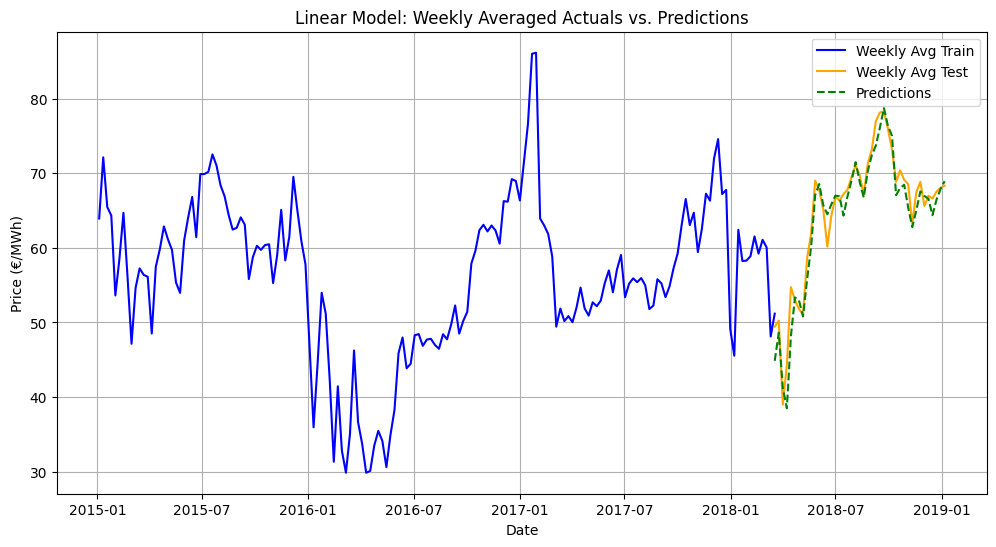

In [55]:
plot_model_preds(pca_train_best_models, "Linear")

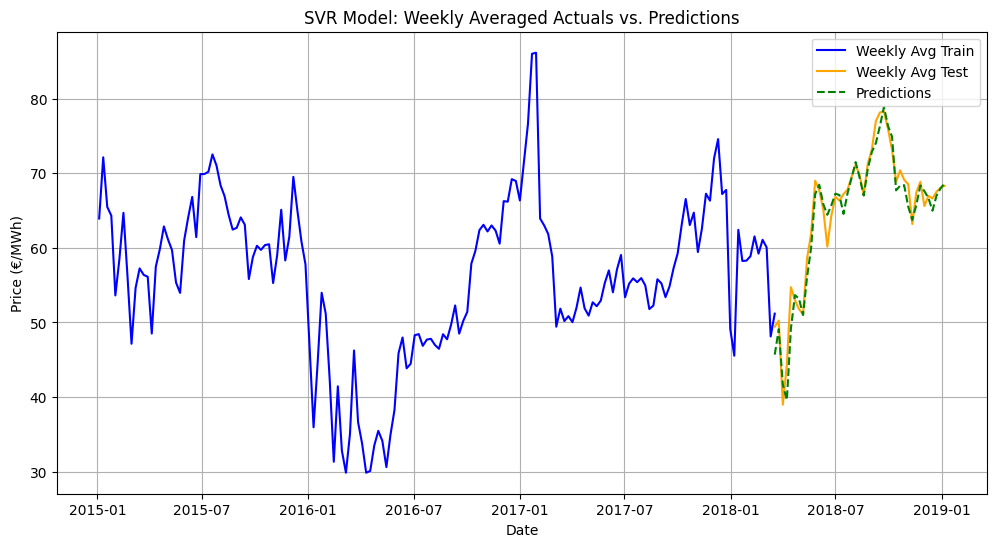

In [58]:
plot_model_preds(pca_train_best_models, "SVR")

In [ ]:
#Export the best performing model for predictions.
joblib.dump(pca_train_best_models.models["Linear"],r"models/best_model_linear_reg.pkl")


['models/best_model_linear_reg.pkl']

Though SVR is the better model in terms of performance metrics, there is not a large difference between the linear model and SVR, in terms of RMSE. In terms of prediction in a business setting, a difference of 0.18 €/MWh is provides roughly an additonal revenue of €45,000,600 (based off total generation in an hour) for the year. The potential revenue is a roughly 1% increase. As such, taking Occam's Razor into account, the linear model was chosen.